<a href="https://colab.research.google.com/github/teerasitk/thaicomRemoteSensing/blob/main/SolutionWorkshopOnAtmosphericCorrection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop on Atmospheric Correction on Sentinel 2
Radiometric correction on Sentinel 2 and geometric corrections

The goal of this assignment is to allow students to practice the radiometric correction 

## 1. Initialize Google Earth Engine

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=lQ_OrO26b3bS8QjtKvdkMsFiU6Hu4KUOK38KcOiUToI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhXRX6jyxvGm5W91d-4jhyV5VYegyhOt--1EEpSZBKa0LSTq5lLFVI

Successfully saved authorization token.


## 2. Install geo-pandas for extracting the polgon coordinate in the shape file.

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 4.8 MB/s 
     |████████████████████████████████| 6.3 MB 22.2 MB/s 
     |████████████████████████████████| 16.7 MB 396 kB/s 


3. Import libraries

In [ ]:
import numpy as np
import geopandas as gpd 
import folium 
from datetime import datetime
import matplotlib.pyplot as plt

## 4. Upload the suvarnabhumi.shp to the Google Colab drive and read the file using the geopandas libary. 

In [ ]:
df = gpd.read_file("/content/suvarnabhumi.shp") # read shape file
df.head() # check the file. 

,id,geometry
0,1,"POLYGON ((100.68797 13.72968, 100.80756 13.730..."


## 5. Clearly, this file has only one row. 

In [ ]:
x,y = df.geometry[0].exterior.coords.xy # extract the coordiate
print(f"Geomerty Type: {df.geom_type}")
cords = np.dstack((x,y)).tolist()[0]
print(f"Coordinates:", cords)

Geomerty Type: 0    Polygon
dtype: object
Coordinates: [[100.68796504713777, 13.729681957930193], [100.80756278796805, 13.730625157779013], [100.80586502824018, 13.614045656464942], [100.68739912722847, 13.613102456616122], [100.68739912722847, 13.613102456616122], [100.68796504713777, 13.729681957930193]]


## 6. Change from the list of coordinates to the Google Earth Engine geometry object. Here, we use the polygon

In [ ]:
aoi = ee.Geometry.Polygon(cords)

## 7. We will work with Sentinel 2 image. Only images that are overlapped with this AOI will be considered. Assume that are interested only the images captured during July, 2021. 



In [ ]:
sen2collections = ee.ImageCollection("COPERNICUS/S2") # create the sentinel 2 image collection object

# here, we access the level 1C data. The DN is proportion to the TOA reflectance
sen2collections = sen2collections.filterDate("2021-07-05", "2021-07-31") # filter for the month of July
# Filter only images captured during July, 2017
sen2collections = sen2collections.filterBounds(aoi)
# filter only images overlapped with our AOI
# check how many images overlapped with our AOI 
num_images = sen2collections.size() # get the number of overlapped images
print(num_images)

It is obsevious that num_images is still the Google Earth Number object. We need to convert it to a number that we can print out.
## 8. To achieve this goal, we will use "getInfo" function.

In [ ]:
num_images = num_images.getInfo()
print(f"There are {num_images} captured during the month of July 2021 that is overlapped with our AOI.")

There are 7 captured during the month of July 2021 that is overlapped with our AOI.


9. Idealy, we prefer images with less clouds. Thus, we will select the image with less than 20% of cloud cover.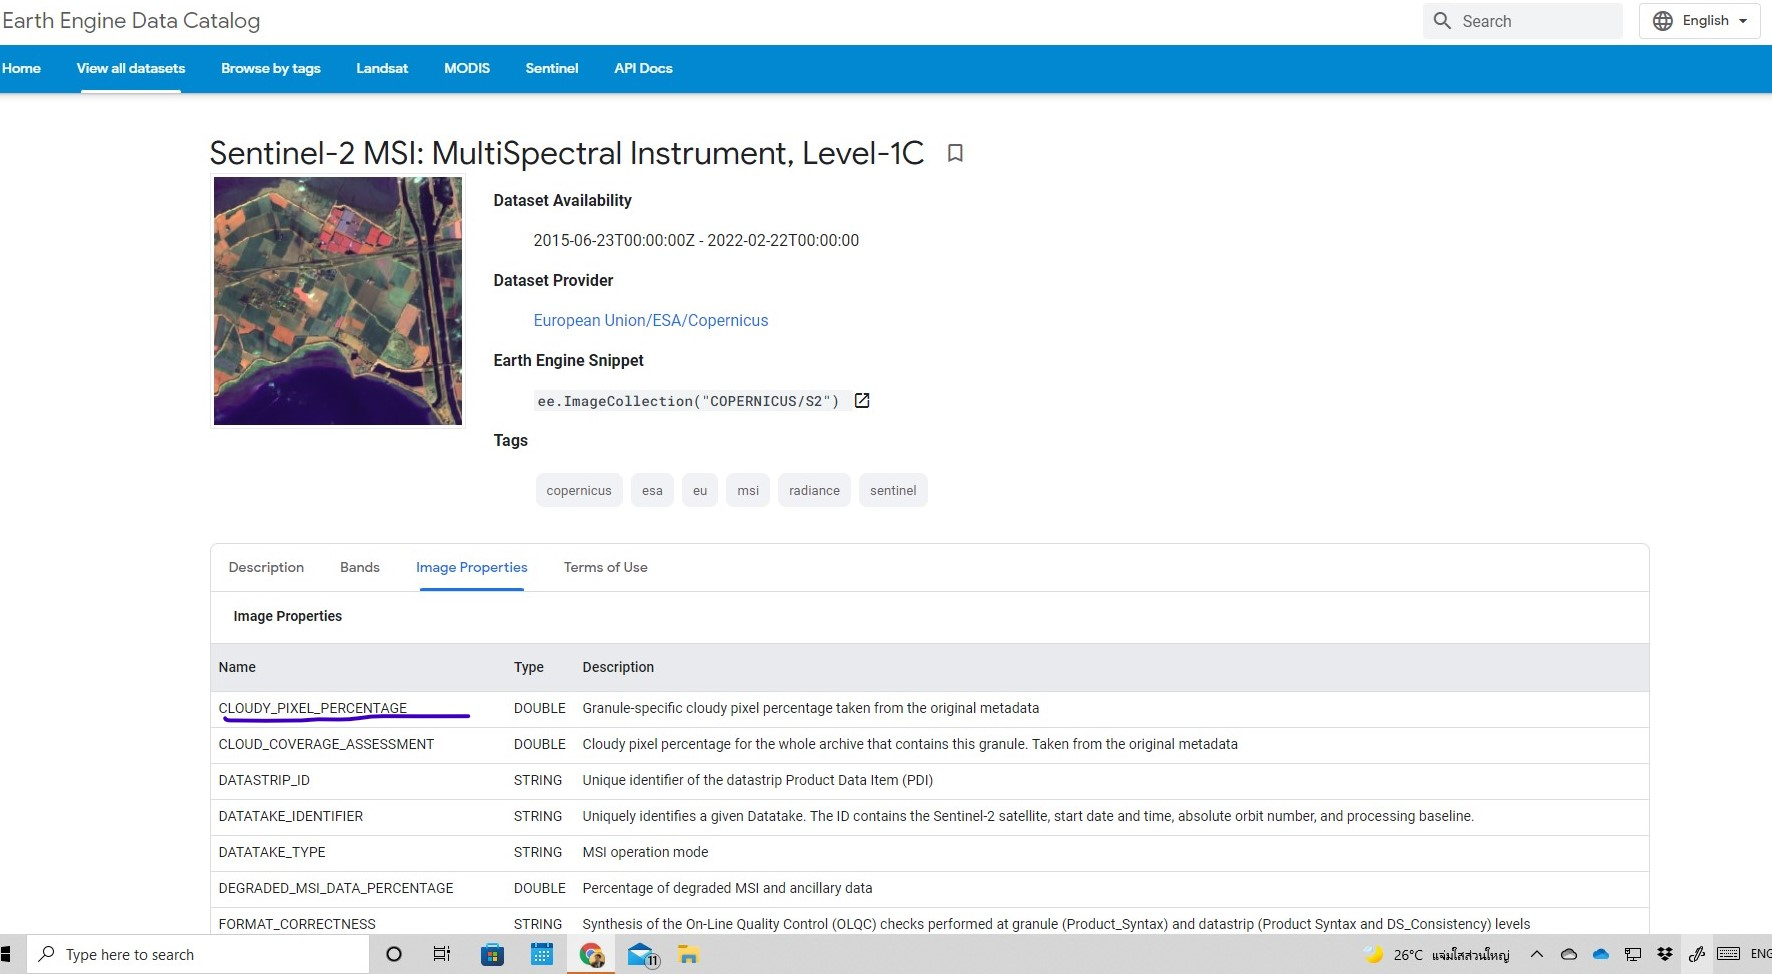

We need to filter for the key "CLOUDY_PIXEL_PERCENTAGE" with values less than 20%

In [ ]:
filter_cloud = ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20) # we create filter 
# cloud cover less than 20%
sen2collections = sen2collections.filter(filter_cloud)
bandsOfInterest = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]
sen2collections = sen2collections.select(bandsOfInterest )
num_images = sen2collections.size().getInfo() # get the number of overlapped images
print(f"Sentinel2 image with less than 20% cloud cover: {num_images}")

Sentinel2 image with less than 20% cloud cover: 1


## 10. Next step is for us to figure out when the image are talken

In [ ]:
sen2collections = sen2collections.sort("system:time_start") # sort by starting time
sen2_list = sen2collections.toList(num_images) 
# Convert the image collection to List so that we can access them by index 
for k in range(num_images): # for each on
  image = ee.Image(sen2_list.get(k)) # get the k-th item
  im_date = int(image.getInfo()['properties']['system:time_start']) 
  # extract date_time in the unix time value (microseconds)
  dateim = datetime.fromtimestamp(im_date/1000) # change to datetime object
  print(dateim)

2021-07-05 03:54:33.469000


## 11. Let us try to display the image on the Google Map. To do this, we will use folium library

In [ ]:
centroid = df.geometry[0].centroid # extract the shape centroid
yc, xc = centroid.y, centroid.x # get lattitude and longitude values
print(xc,yc) # print the value
folium_map = folium.Map(location=[yc, xc], zoom_start=13) #lon, lat and at zoom level 13 (more value higher detail)
basemaps = {'Google Maps': folium.TileLayer(
    tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',  #google map service site
    attr = 'Google',  
    name = 'Google Maps', 
    overlay = True,
    control=True)} # tell folium that the base map is the google map. 
basemaps['Google Maps'].add_to(folium_map) # add google earth data into ku_map
folium_map

100.74719813140922 13.67195618504144


## We also need to convert the DN to the surface reflectance. To do this, we will multiply all bands by $0.0001$.

In [ ]:
from ee import geometry
sen2collections = sen2collections.sort("system:time_start")
sen2_list = sen2collections.toList(num_images)
for k in range(num_images):  
  image = ee.Image(sen2_list.get(k))
  im_date = int(image.getInfo()['properties']['system:time_start'])
  image = image.multiply(0.0001)
  dateim = datetime.fromtimestamp(im_date/1000)  
  image_scene = image.clip(aoi) #Clip to only in AOI
  #To show image on a map, we need to build a visualization parameter first
  num_pix = image.reduceRegion(ee.Reducer.count(), geometry=aoi).getInfo()
  viz_params = {'bands':['B8','B3','B2'], 'min': 0,'max': 0.5} 
# red: B8, green: B3, blue: B2 with min of 0 and max of 0.5
  image_map_obj = image_scene.getMapId(viz_params) # convert image into map object
  folium.TileLayer(
    tiles=image_map_obj ['tile_fetcher'].url_format, #item where the image is linked to
    overlay=True,
    attr='Original Image',
    name=f'True Color Composite',
    ).add_to(folium_map)

folium_map

# Question1: What did you see in the above display?
____________________A lot of Smoke!!!!! There was FIREEEEE___________________

# Question 2: Plot Histogram of all bands using the Google Earth Engine with 256 bins. Here, use "image" variable since it is the toa reflectance

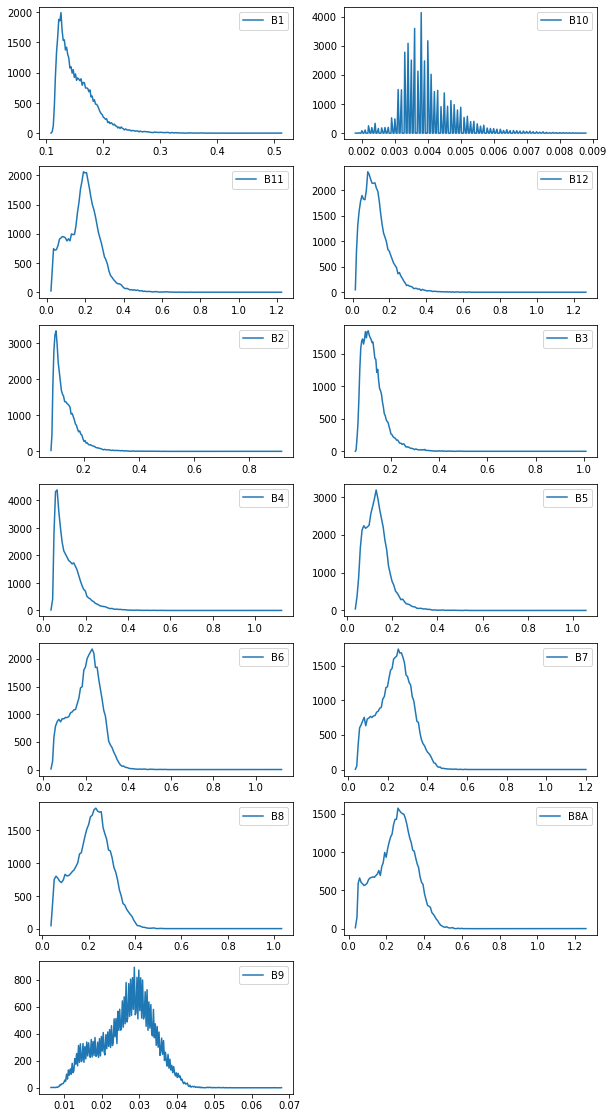

In [ ]:
#bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]
# code is here
plt.figure(figsize=(10,20))
hist = image.reduceRegion(ee.Reducer.histogram(maxBuckets=256), geometry=aoi).getInfo() # hist of our 
cnt = 1
for key, value in hist.items():
  x = value['bucketMeans']
  y = value['histogram']
  plt.subplot(7,2,cnt)
  plt.plot(x,y, label=f"{key}")
  plt.legend()
  cnt +=1

12. From Sentinel  [website](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-1c/algorithm), the TOA reflectance in the level 1C product is given as

    $\rho_k^T(i,j)=\frac{\pi CN_{k}(i,j)}{A_{k}E_sd(t)\cos(\theta_s(i,j))}$

where:
 * $ CN_{k}$ is the equalized DN at pixel (i,j)
 * $E_s$ is the extra-terrestrial solar spectrum
 * $d(t)=\frac{1}{\left(1-0.01673\cos\left(0.01752(t-2)\right)\right)^2}$   is the correction for the sun-Earth distance.
 * $\theta_s$ is the sun zenith angles (in degrees) witch can be extracted from the "MEAN_INCIDENCE_ZENITH_ANGLE_XX" properties.
 * $E_s$ is given in the properties "SOLAR_IRRADIANCE_XX" where XX denotes the band name.
 * $A_k$ = 0.0001

 We can recover the $TOA$ radiance by using

 $L^{sat}_k(i,j)=\frac{A_kE_s\cos(\theta_s)CN_{k}(i,j)}{\pi d^2(t)}$


Here, $t$ s the Julian Day (reference day:1-Jan-1950)

To compute the Julian Day, we are using the pandas library. 

In [ ]:
import pandas as pd 
scene_date = pd.Timestamp(year = dateim.year,  month = dateim.month, day = dateim.day) 
ref_date = pd.Timestamp(year = 1950,  month = 1, day = 1) 
t = scene_date.to_julian_date() - ref_date.to_julian_date()
print(t)

26118.0


# Question 3: Compute the TAO radiance on the Sentinel 2 on this scene

In [44]:
# your code is here.
toa_radiance = None # initialize as Nont
imorg = ee.Image(sen2_list.get(0))
toa_radiance = None # initialize as Nont
d = 1/((1-0.001673*np.cos(0.01752*(t-2)))**2)
for band in bandsOfInterest: #'B2', 'B3', 'B4', 'B5'
  AE = imorg.getInfo()['properties'][f'SOLAR_IRRADIANCE_{band}'] * 0.0001# 
  theta = imorg.getInfo()['properties'][f'MEAN_SOLAR_ZENITH_ANGLE'] # 
  print(f"{band}: M: {AE}, A: {theta}") 
  factor = AE * np.cos(theta*np.pi/180) / (np.pi * d*d)
  if toa_radiance is None:
    toa_radiance = imorg.select(band)
    toa_radiance = toa_radiance.multiply(factor)
  else:
    toa_radiancek = imorg.select(band)
    toa_radiancek = toa_radiancek .multiply(factor)
    toa_radiance = toa_radiance.addBands(toa_radiancek ) # add band into toa_radiance
  


B1: M: 0.18846900000000003, A: 22.7026750644684
B2: M: 0.19596600000000003, A: 22.7026750644684
B3: M: 0.182324, A: 22.7026750644684
B4: M: 0.151206, A: 22.7026750644684
B5: M: 0.142464, A: 22.7026750644684
B6: M: 0.128761, A: 22.7026750644684
B7: M: 0.11620799999999999, A: 22.7026750644684
B8: M: 0.10416300000000002, A: 22.7026750644684
B8A: M: 0.095532, A: 22.7026750644684
B9: M: 0.081292, A: 22.7026750644684
B11: M: 0.024559, A: 22.7026750644684
B12: M: 0.008525, A: 22.7026750644684


# Question 4: Display your Image on the folium library just like in the demonstractin

In [ ]:
# your code is here
maximum_toa = toa_radiance.reduceRegion(ee.Reducer.percentile([98]), geometry=aoi).getInfo() # Get 98% percentile
minimum_toa = toa_radiance.reduceRegion(ee.Reducer.percentile([2]), geometry=aoi).getInfo() # Get 2% percentile
print(maximum_toa)
print(minimum_toa)
#To show image on a map, we need to build a visualization parameter first
viz_params = {'bands':['B8','B3','B2'], 
              'min': min(minimum_toa.values()), 
              'max': max(maximum_toa.values())} 
image_scene = toa_radiance.clip(aoi)
# red: B8, green: B3, blue: B2 with min of 0 and max of 0.5
image_map_obj = image_scene.getMapId(viz_params) # convert image into map object
folium.TileLayer(
  tiles=image_map_obj ['tile_fetcher'].url_format, #item where the image is linked to
  overlay=True,
  attr='Original Image',
  name=f'True Color Composite',
  ).add_to(folium_map)

folium_map

{'B1': 135.46741749809124, 'B10': 0.6879918848977793, 'B11': 27.73814426765702, 'B12': 8.063818034405637, 'B2': 148.87740998549103, 'B3': 142.98267227187353, 'B4': 129.0376268487158, 'B5': 114.97431823025863, 'B6': 127.04370016529255, 'B7': 139.0028108402943, 'B8': 112.95335070284658, 'B8A': 123.00318197004825, 'B9': 9.47029799942386}
{'B1': 63.55968053044086, 'B10': 0.257996956836665, 'B11': 2.7600673689494992, 'B12': 0.5640393395270237, 'B2': 51.082214773084836, 'B3': 37.11404684527178, 'B4': 21.14716724285753, 'B5': 21.12355685391179, 'B6': 21.048343585436513, 'B7': 21.002927845329175, 'B8': 15.07463390263861, 'B8A': 15.02676690026564, 'B9': 2.8437989844570324}


# Question 5: Plot the histogram of the TAO radiance of all bands using the google earth engine with 256 bins.

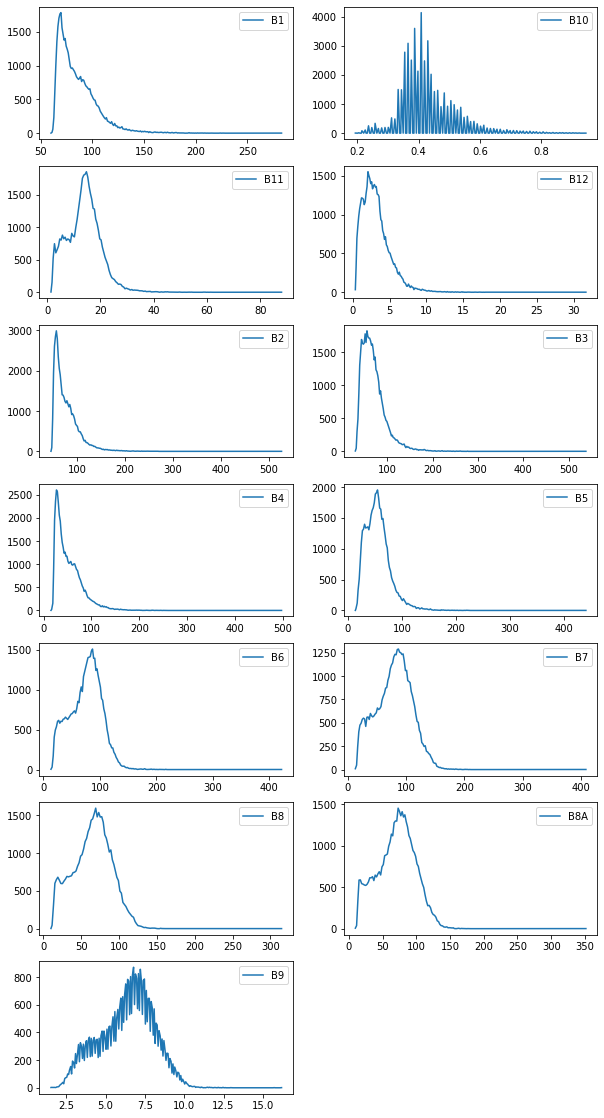

In [ ]:
plt.figure(figsize=(10,20))
hist = toa_radiance.reduceRegion(ee.Reducer.histogram(maxBuckets=256), geometry=aoi).getInfo() # hist of our 
cnt = 1
for key, value in hist.items():
  x = value['bucketMeans']
  y = value['histogram']
  plt.subplot(7,2,cnt)
  plt.plot(x,y, label=f"{key}")
  plt.legend()
  cnt +=1

## 13. From our optical radiation model, we have

$L_k^{sat}(i,j)=\rho_k^{B}(i,j)\tau_k\left(E_{dir} + E_{dif}\right) + L_p$

Thus, to compute $\rho_k^{B}(i,j)$, we need to estimate $E_{dir}$, $E_{dif}$, $L_p$ and $\tau_k$

where
*  $\rho_k^{B}(i,j)$ is the surface reflectance.
*  $E_{dir}$ is the direct solar irradiance.
*  $E_{dif}$ is the diffuse solar irradiance.
* $L_p$ is the path radiance.





Using the SixS modules, to compute these values for each bands 1-12

In [ ]:
!wget http://rtwilson.com/downloads/6SV-1.1.tar
!tar xf 6SV-1.1.tar # unzip

--2022-03-09 03:13:52--  http://rtwilson.com/downloads/6SV-1.1.tar
Resolving rtwilson.com (rtwilson.com)... 173.236.224.184
Connecting to rtwilson.com (rtwilson.com)|173.236.224.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075520 (3.9M) [application/x-tar]
Saving to: ‘6SV-1.1.tar’

6SV-1.1.tar         100%[===================>]   3.89M  15.1MB/s    in 0.3s    

2022-03-09 03:13:52 (15.1 MB/s) - ‘6SV-1.1.tar’ saved [4075520/4075520]



In [ ]:
import os
os.chdir("/content/6SV1.1")
!make 
# replace FC = gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none $(FFLAGS) in LINE 8

gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none -O -O  -c -o AATSR.o AATSR.f
gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none -O -O  -c -o ABSTRA.o ABSTRA.f
gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none -O -O  -c -o AEROSO.o AEROSO.f
gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none -O -O  -c -o AKTOOL.o AKTOOL.f
AKTOOL.f:1570:16:

       call dakg(uu, aa, n)
                1
AKTOOL.f:1579:16:

       call dakg(uu, aa, n)
                1
gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none -O -O  -c -o ATMREF.o ATMREF.f
gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none -O -O  -c -o AVHRR.o AVHRR.f
gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none -O -O  -c -o BBM.o BBM.f
gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none -O -O  -c -o BDM.o BDM.f
gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none -O -O  -c -o BRDFGRID.o BRDFGRID.f
gfortran -std=lega

In [ ]:
import os
os.environ["PATH"]="/content/6SV1.1:"+os.environ["PATH"]
!sixsV1.1 < /content/Examples/Example_In_1.txt # try on example

In [ ]:
#install py6s
!pip install py6s

     |████████████████████████████████| 80 kB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 4.6 MB/s 
  Created wheel for py6s: filename=Py6S-1.9.1-py3-none-any.whl size=92225 sha256=a1e461cfdbea248f1d6387f4a9cd20013b43c292a2577958ec92b4c1ba23025a
  Stored in directory: /root/.cache/pip/wheels/40/38/cd/138fd6f0a11b9b36e5577060a84b2db49e4c01a55df5fcdd86
Successfully built py6s


In [ ]:
from Py6S import PredefinedWavelengths, SixS, Wavelength, AtmosProfile, AeroProfile,Geometry
SixS().test()

6S wrapper script by Robin Wilson
Using 6S located at /content/6SV1.1/sixsV1.1
Running 6S using a set of test parameters
6sV version: 1.1
The results are:
Expected result: 619.158000
Actual result: 619.158000
#### Results agree, Py6S is working correctly


0

In [ ]:
def getwaterVapor(date:ee.Date,
                  aoi:ee.Geometry)->float:
  """
    Water vapour column above target at time of image aquisition.    
    (Kalnay et al., 1996, The NCEP/NCAR 40-Year Reanalysis Project. Bull. 
    Amer. Meteor. Soc., 77, 437-471)
  """
  # data are recorded every 6 hours. We round off the time to 6 hours
  y = date.get('year')
  m = date.get('month')
  d = date.get('day')
  H = date.get('hour')
  HH = H.divide(6).round().multiply(6)
  round_date = date.fromYMD(y,m,d).advance(HH,'hour')
  water_imc = ee.ImageCollection('NCEP_RE/surface_wv').filterDate(round_date, round_date.advance(1,'day'))
  water_im = water_imc.first()
  # water_vapour at target
  water = water_im.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi.centroid()).get('pr_wtr')
  # convert to Py6S units (Google = kg/m^2, Py6S = g/cm^2)
  water = ee.Number(water).divide(10)     
  return water.getInfo()
def getOzone(date:ee.Date,
             aoi:ee.Geometry)->float:
  # filtered ozone collection
  # Data is recorded every day
  # We round off to 24 hour
  y = date.get('year')
  m = date.get('month')
  d = date.get('day')
  H = date.get('hour')
  HH = H.divide(24).round().multiply(24)
  round_date = date.fromYMD(y,m,d).advance(HH,'hour')
  ozone_imc = ee.ImageCollection('TOMS/MERGED').filterDate(round_date, 
                                                          round_date.advance(1,'month'))
      
  # ozone image
  ozone_im = ozone_imc.first()      
  
  ozone = ozone_im.reduceRegion(reducer=ee.Reducer.mean(), 
                                geometry=aoi.centroid()).get('ozone')
  ozone = ee.Number(ozone).divide(1000)# (i.e. Dobson units are milli-atm-cm )        
      
  return ozone.getInfo()
def getAerosol(date:ee.Date,             
               aoi:ee.Geometry)->float:
  """
      European Centre for Medium-Range Weather Forecasts (ECMWF)
      Data recored every 5 days.
  """

  aot_imc = ee.ImageCollection("ECMWF/CAMS/NRT")
  aot_imc = aot_imc.filterDate(date,  date.advance(5, 'days'))
  aot_im = aot_imc.first()
  aot = aot_im.reduceRegion(reducer=ee.Reducer.mean(),
                            geometry=aoi.centroid()).get('total_aerosol_optical_depth_at_550nm_surface')
     
      
  return aot.getInfo()

In [ ]:
import math 
def spectralResponseFunction(bandname, sat):
  """
  Extract spectral response function for given band name
  """
  if sat == "Sentinel-2A":
    bandSelect = {
                  'B1':PredefinedWavelengths.S2A_MSI_01,
                  'B2':PredefinedWavelengths.S2A_MSI_02,
                  'B3':PredefinedWavelengths.S2A_MSI_03,
                  'B4':PredefinedWavelengths.S2A_MSI_04,
                  'B5':PredefinedWavelengths.S2A_MSI_05,
                  'B6':PredefinedWavelengths.S2A_MSI_06,
                  'B7':PredefinedWavelengths.S2A_MSI_07,
                  'B8':PredefinedWavelengths.S2A_MSI_08,
                  'B8A':PredefinedWavelengths.S2A_MSI_8A,
                  'B9':PredefinedWavelengths.S2A_MSI_09,
                  'B10':PredefinedWavelengths.S2A_MSI_10,
                  'B11':PredefinedWavelengths.S2A_MSI_11,
                  'B12':PredefinedWavelengths.S2A_MSI_12,
                  }
  elif sat == "Sentinel-2B":
    bandSelect = {
                  'B1':PredefinedWavelengths.S2B_MSI_01,
                  'B2':PredefinedWavelengths.S2B_MSI_02,
                  'B3':PredefinedWavelengths.S2B_MSI_03,
                  'B4':PredefinedWavelengths.S2B_MSI_04,
                  'B5':PredefinedWavelengths.S2B_MSI_05,
                  'B6':PredefinedWavelengths.S2B_MSI_06,
                  'B7':PredefinedWavelengths.S2B_MSI_07,          
                  'B8':PredefinedWavelengths.S2B_MSI_08,
                  'B8A':PredefinedWavelengths.S2B_MSI_8A,
                  'B9':PredefinedWavelengths.S2B_MSI_09,
                  'B10':PredefinedWavelengths.S2B_MSI_10,
                  'B11':PredefinedWavelengths.S2B_MSI_11,
                  'B12':PredefinedWavelengths.S2B_MSI_12,          
                  }
  elif  sat == "Landsat-8OLI":
     bandSelect = {
                   'B1':PredefinedWavelengths.LANDSAT_OLI_B1,
                   'B2':PredefinedWavelengths.LANDSAT_OLI_B2,
                   'B3':PredefinedWavelengths.LANDSAT_OLI_B3,
                   'B4':PredefinedWavelengths.LANDSAT_OLI_B4,
                   'B5':PredefinedWavelengths.LANDSAT_OLI_B5,
                   'B6':PredefinedWavelengths.LANDSAT_OLI_B6,
                   'B7':PredefinedWavelengths.LANDSAT_OLI_B7,
                   'B8':PredefinedWavelengths.LANDSAT_OLI_B8,
                   'B9':PredefinedWavelengths.LANDSAT_OLI_B9,
                   'PAN':PredefinedWavelengths.LANDSAT_OLI_PAN
                  }
  return Wavelength(bandSelect[bandname])

In [ ]:
def surface_reflectanceFromRadiance(bandname, radiance, sat, s):
  """
  Calculate surface reflectance from at-sensor radiance given waveband name
  """

  # run 6S for this waveband
  s.wavelength = spectralResponseFunction(bandname, sat)
  s.run()

  # extract 6S outputs
  Edir = s.outputs.direct_solar_irradiance             #direct solar irradiance
  Edif = s.outputs.diffuse_solar_irradiance            #diffuse solar irradiance
  Lp   = s.outputs.atmospheric_intrinsic_radiance      #path radiance
  absorb  = s.outputs.trans['global_gas'].upward       #absorption transmissivity
  scatter = s.outputs.trans['total_scattering'].upward #scattering transmissivity
  tau2 = absorb*scatter                                #total transmissivity
  print(f"Correction Band {bandname} with Edir: {Edir}," +
        f"Edif: {Edif}, Lp: {Lp}, absorb: {absorb}, scatter: {scatter}, trns:{tau2}!")
  # radiance to surface reflectance

  ref = radiance.subtract(Lp)#.multiply(math.pi).divide(tau2*(Edir+Edif))    
  mask = ref.gt(0.0).cast({bandname:'float'})
  ref = ref.multiply(mask)
  refl = ref.multiply(math.pi).divide(tau2*(Edir+Edif))    
  return refl

In [ ]:
s = SixS() # initialize 6S
capture_date = ee.Date(dateim )
h2o = getwaterVapor(capture_date, aoi) # get water
o3 = getOzone(capture_date, aoi) # get Ozne
aot = getAerosol(capture_date, aoi)# get aerosol
print(h2o, o3, aot)
# Atmospheric constituents
s.atmos_profile = AtmosProfile.UserWaterAndOzone(h2o,o3)
s.aero_profile = AeroProfile.Continental
s.aot550 = aot
SRTM = ee.Image('CGIAR/SRTM90_V4')# Shuttle Radar Topography mission covers *most* of the Earth
alt = SRTM.reduceRegion(reducer = 
                        ee.Reducer.mean()
                        ,geometry = aoi).get(
                          'elevation').getInfo()
km = alt/1000 # i.e. Py6S uses units of kilometers # get altitude
print(f"The altitude of the scene is {km} km.")
print(f"Image was taken at {dateim }.")

4.490000152587891 0.273 0.3248876631259918
The altitude of the scene is 0.0031983565446652854 km.
Image was taken at 2021-07-05 03:54:33.469000.


In [ ]:
# Earth-Sun-satellite geometry
s.geometry = Geometry.User()
s.geometry.view_z = 0               #  Assume NADIR 
s.geometry.month = dateim.month # month and day used for Earth-Sun distance
s.geometry.day = dateim.day     # month and day used for Earth-Sun distance
s.altitudes.set_sensor_satellite_level()
s.altitudes.set_target_custom_altitude(km)

# Question 6: Fill in the Blank


1.   $E_{dir}$ for B1= _________________________, $E_{dif}$ for B1= _________________________, and $L_{p}$ for B1= _________________________. 
2.   $E_{dir}$ for B2= _________________________, $E_{dif}$ for B2= _________________________, and $L_{p}$ for B2= _________________________. 
3.   $E_{dir}$ for B3= _________________________, $E_{dif}$ for B3= _________________________, and $L_{p}$ for B3= _________________________. 
4.   $E_{dir}$ for B4= _________________________, $E_{dif}$ for B4= _________________________, and $L_{p}$ for B4= _________________________. 
5.   $E_{dir}$ for B5= _________________________, $E_{dif}$ for B5= _________________________, and $L_{p}$ for B5= _________________________. 
6.   $E_{dir}$ for B6= _________________________, $E_{dif}$ for B6= _________________________, and $L_{p}$ for B6= _________________________. 
7.   $E_{dir}$ for B7= _________________________, $E_{dif}$ for B7= _________________________, and $L_{p}$ for B7= _________________________. 
8.   $E_{dir}$ for B8= _________________________, $E_{dif}$ for B8= _________________________, and $L_{p}$ for B8= _________________________. 

9.   $E_{dir}$ for B8A= _________________________, $E_{dif}$ for B8A= _________________________, and $L_{p}$ for B8A= _________________________. 

10.   $E_{dir}$ for B9= _________________________, $E_{dif}$ for B9= _________________________, and $L_{p}$ for B9= _________________________. 
11.   $E_{dir}$ for B11= _________________________, $E_{dif}$ for B11= _________________________, and $L_{p}$ for B11= _________________________. 
12.   $E_{dir}$ for B12= _________________________, $E_{dif}$ for B12= _________________________, and $L_{p}$ for B12= _________________________. 

# Question 7: Compute the surface reflectance using the computed values above using Google Earth Engine.

In [ ]:
imorg.getInfo()['properties']['SPACECRAFT_NAME'], imorg.getInfo()['properties'][f"MEAN_SOLAR_AZIMUTH_ANGLE"]

('Sentinel-2A', 63.9876503272912)

In [ ]:
surface_refl = None 
sat_name = imorg.getInfo()['properties']['SPACECRAFT_NAME']
for band in bandsOfInterest:
  radiance = toa_radiance.select(band)
  if surface_refl is None:
    solar_zenith = imorg.getInfo()['properties']["MEAN_SOLAR_ZENITH_ANGLE"]#[f'MEAN_INCIDENCE_ZENITH_ANGLE_{band}']
    s.geometry.solar_z = solar_zenith        # solar zenith angle
    surface_refl = surface_reflectanceFromRadiance(band, radiance, sat_name, s)
  else:
    #solar_zenith = imorg.getInfo()['properties'][f'MEAN_INCIDENCE_ZENITH_ANGLE_{band}']
    #s.geometry.solar_z = solar_zenith
    new_band = surface_reflectanceFromRadiance(band, radiance, sat_name, s)
    surface_refl = surface_refl.addBands(new_band)

Correction Band B1 with Edir: 845.291,Edif: 505.564, Lp: 60.266, absorb: 0.9993, scatter: 0.81781, trns:0.817237533!
Correction Band B2 with Edir: 979.405,Edif: 467.941, Lp: 43.771, absorb: 0.99316, scatter: 0.8569, trns:0.851038804!
Correction Band B3 with Edir: 1027.656,Edif: 383.486, Lp: 26.805, absorb: 0.971, scatter: 0.8909, trns:0.8650639!
Correction Band B4 with Edir: 953.246,Edif: 264.997, Lp: 13.962, absorb: 0.97461, scatter: 0.92071, trns:0.8973331731!
Correction Band B5 with Edir: 874.264,Edif: 220.491, Lp: 10.912, absorb: 0.95274, scatter: 0.92824, trns:0.8843713776!
Correction Band B6 with Edir: 820.429,Edif: 190.406, Lp: 8.876, absorb: 0.95057, scatter: 0.9329, trns:0.886786753!
Correction Band B7 with Edir: 798.157,Edif: 168.071, Lp: 7.227, absorb: 0.98599, scatter: 0.93793, trns:0.9247896007!
Correction Band B8 with Edir: 691.499,Edif: 132.509, Lp: 5.529, absorb: 0.93252, scatter: 0.9423, trns:0.878713596!
Correction Band B8A with Edir: 691.878,Edif: 123.77, Lp: 4.804, 

# Question 8: Plot the histogram of the surface reflectance of all bands using the google earth engine with 256 bins.

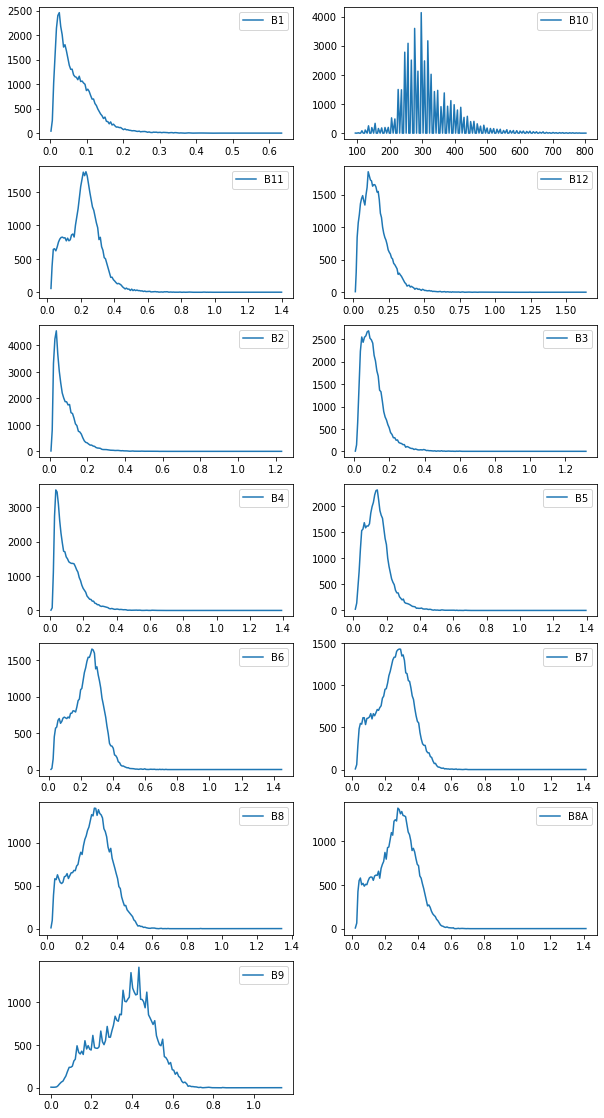

In [ ]:
# your code is here
plt.figure(figsize=(10,20))
hist = surface_refl.reduceRegion(ee.Reducer.histogram(maxBuckets=256), geometry=aoi).getInfo() # hist of our 
cnt = 1
for key, value in hist.items():
  x = value['bucketMeans']
  y = value['histogram']
  plt.subplot(7,2,cnt)
  plt.plot(x,y, label=f"{key}")
  plt.legend()
  cnt +=1

# Question 9: Display this image on the folium.

In [ ]:
# your code is here.
# your code is here
maximum_toa = surface_refl.reduceRegion(ee.Reducer.percentile([98]), geometry=aoi).getInfo() # Get 98% percentile
minimum_toa = surface_refl.reduceRegion(ee.Reducer.percentile([2]), geometry=aoi).getInfo() # Get 2% percentile
print(maximum_toa)
print(minimum_toa)
#To show image on a map, we need to build a visualization parameter first
viz_params = {'bands':['B8','B3','B2'], 
              'min': 0, 
              'max': 0.5} 
image_scene = surface_refl.clip(aoi)
# red: B8, green: B3, blue: B2 with min of 0 and max of 0.5
image_map_obj = image_scene.getMapId(viz_params) # convert image into map object
folium.TileLayer(
  tiles=image_map_obj ['tile_fetcher'].url_format, #item where the image is linked to
  overlay=True,
  attr='Original Image',
  name=f'True Color Composite',
  ).add_to(folium_map)

folium_map

{'B1': 0.2129656047030805, 'B10': 559.6557780814178, 'B11': 0.44144043861257054, 'B12': 0.4179696599479466, 'B2': 0.2691313021766158, 'B3': 0.3004583269775451, 'B4': 0.3244272242055287, 'B5': 0.3397252704773757, 'B6': 0.4176691880332767, 'B7': 0.46486595648854867, 'B8': 0.47243190754157105, 'B8A': 0.48817640883117475, 'B9': 0.6126389454735937}
{'B1': 0.010053179539032822, 'B10': 154.51700067788644, 'B11': 0.03549739517306519, 'B12': 0.02759784798884773, 'B2': 0.019994983090640184, 'B3': 0.027782675973554126, 'B4': 0.02057643709495358, 'B5': 0.03548381349999156, 'B6': 0.043231494667913525, 'B7': 0.05088228499999854, 'B8': 0.04311244857708915, 'B8A': 0.04308905990002094, 'B9': 0.09841747514900143}


# Question 10: Load the same image in the same AOI using the Google Earth Surface Reflectance (Level 2A) using ee.Image("COPERNICUS/S2_SR"), and compare the histograms from both original Sentinel2 Level 2A and our generated data in Question 8.

In [ ]:
# Your code is here.
sen2collections = ee.ImageCollection("COPERNICUS/S2_SR") # create the sentinel 2 image collection object

# here, we access the level 1C data. The DN is proportion to the TOA reflectance
sen2collections = sen2collections.filterDate("2021-07-05", "2021-07-31") # filter for the month of July
# Filter only images captured during July, 2017
sen2collections = sen2collections.filterBounds(aoi)
# filter only images overlapped with our AOI
# check how many images overlapped with our AOI 
num_images = sen2collections.size() # get the number of overlapped images
num_images = num_images.getInfo()
print(f"There are {num_images} captured during the month of July 2021 that is overlapped with our AOI.")

There are 7 captured during the month of July 2021 that is overlapped with our AOI.


In [ ]:
filter_cloud = ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20) # we create filter 
# cloud cover less than 20%
sen2collections = sen2collections.filter(filter_cloud)
bandsOfInterest = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9",  "B11", "B12"]
sen2collections = sen2collections.select(bandsOfInterest )
num_images = sen2collections.size().getInfo() # get the number of overlapped images
print(f"Sentinel2 image with less than 20% cloud cover: {num_images}")

Sentinel2 image with less than 20% cloud cover: 1


In [ ]:
from ee import geometry
sen2collections = sen2collections.sort("system:time_start")
sen2_list = sen2collections.toList(num_images)

image = ee.Image(sen2_list.get(0))
im_date = int(image.getInfo()['properties']['system:time_start'])
image = image.multiply(0.0001)
dateim = datetime.fromtimestamp(im_date/1000)  
image_scene = image.clip(aoi) #Clip to only in AOI
#To show image on a map, we need to build a visualization parameter first
num_pix = image.reduceRegion(ee.Reducer.count(), geometry=aoi).getInfo()
viz_params = {'bands':['B8','B3','B2'], 'min': 0,'max': 0.5} 
# red: B8, green: B3, blue: B2 with min of 0 and max of 0.5
image_map_obj = image_scene.getMapId(viz_params) # convert image into map object
folium.TileLayer(
  tiles=image_map_obj ['tile_fetcher'].url_format, #item where the image is linked to
  overlay=True,
  attr='Original Image',
  name=f'True Color Composite',
  ).add_to(folium_map)

folium_map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


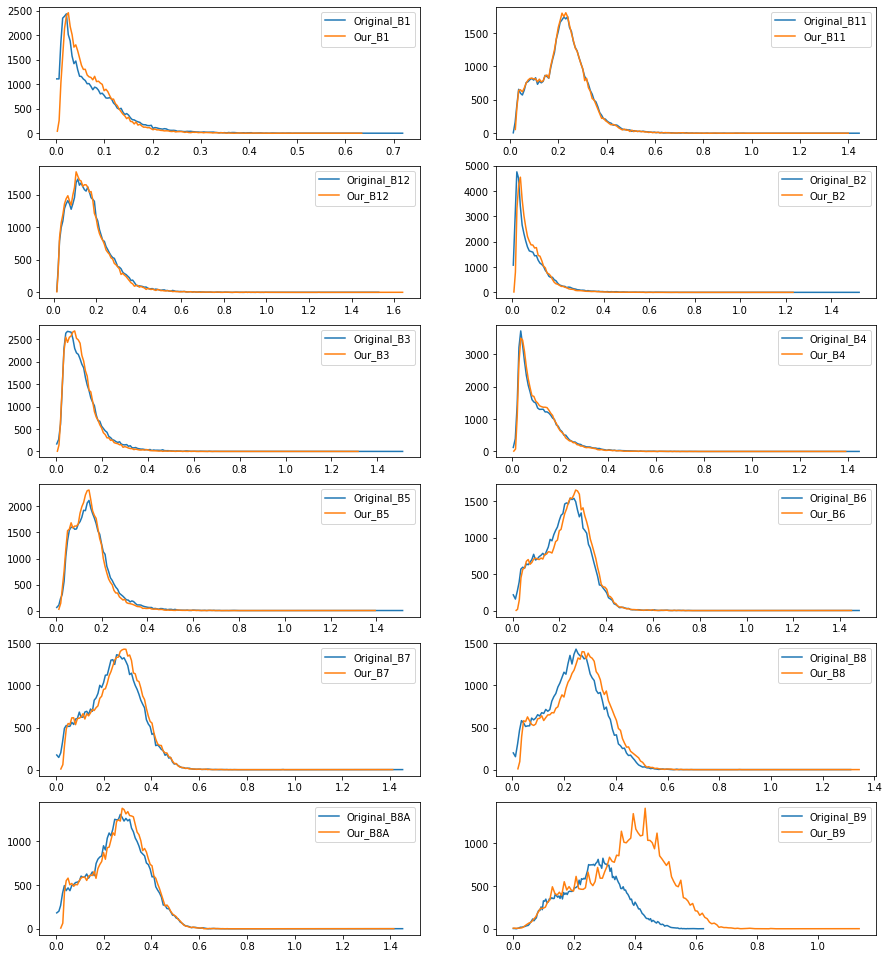

In [ ]:
# your code is here
plt.figure(figsize=(15,20))
hist1 = surface_refl.reduceRegion(ee.Reducer.histogram(maxBuckets=256), geometry=aoi).getInfo() # hist of our 
hist2 = image.reduceRegion(ee.Reducer.histogram(maxBuckets=256), geometry=aoi).getInfo() # hist of our 
cnt = 1
for key, value in hist2.items():
  x = value['bucketMeans']
  y = value['histogram']
  plt.subplot(7,2,cnt)
  plt.plot(x,y, label=f"Original_{key}")
  value = hist1[key]
  x = value['bucketMeans']
  y = value['histogram']
  plt.subplot(7,2,cnt)
  plt.plot(x,y, label=f"Our_{key}")
  plt.legend()
  cnt +=1